# Multi-armed bandit implementation

In the [multi-armed bandit (MAB)](https://en.wikipedia.org/wiki/Multi-armed_bandit) problem we try to maximise our gain over time by "gambling on slot-machines (or bandits)" that have different but unknown expected outcomes. 

The concept is typically used as an alternative to [A/B-testing](https://en.wikipedia.org/wiki/A/B_testing) used in marketing research or website optimization. For example, testing which marketing email leads to the most newsletter signups, or which webshop design leads to the most sales.

The benefit of viewing website optimization as a multi-armed bandit problem instead of an A/B-testing problem is that no pre-defined sample sizes are needed and the algorithm will start optimizing the outcome (e.g. click rate) from the beginning. While the A/B-test needs to run all predefined samples to make a conclusion.

What follows will illustrate how to implement and solve a very simple multi-armed bandit problem with a probabilistic algorithm.

In [1]:
# Imports
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import numpy as np
import scipy
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
np.random.seed(42)
#

## Defining the bandit experiment

We will simulate 3 bandits with each an underlying probability of winning stored in `p_bandits`. The `pull(i)` method will "pull the arm" of bandit $i$ and randomly decides if the pull was a win (1) or not (0) based on the underlying probability.

In [2]:
# Define the multi-armed bandits
nb_bandits = 3  # Number of bandits
# True probability of winning for each bandit
p_bandits = [0.45, 0.55, 0.60]


def pull(i):
    """Pull arm of bandit with index `i` and return 1 if win, 
    else return 0."""
    if np.random.rand() < p_bandits[i]:
        return 1
    else:
        return 0

## Bayesian interpretation

Each pull of a specifc bandit will result in a win with a certain probability. The higher this probability the more likely pulling the arm of the bandit is going to result in a win. However we don't know what this probability is so we will have to model it based on our observations of a certain bandit resulting in a win or not. We are going to model the unkown probability with a parameter $\theta$. Based on oberving a single outcome $x$ we can model this as the distribution $P(\theta \mid x)$. Using [Bayes rule](https://en.wikipedia.org/wiki/Bayes%27_theorem) we can write this as:

$$
P(\theta \mid x) = \frac{P(x \mid \theta)P(\theta)}{P(x)}
$$

$P(\theta \mid x)$ is called the posterior distribution of $\theta$ after observing $x$. We will be able to compute this via the likelihood $P(x \mid \theta)$ and prior $P(\theta)$. In this case the likelihood function $P(x \mid \theta)$ follows the [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution). 


### Beta prior

A good choice for the prior $P(\theta)$ would be the [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) since it is a [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior#Discrete_distributions) to the Bernoulli distribution. 
This means that if the likelihood function $P(x \mid \theta)$ is Bernoulli distributed and the prior distribution  $P(\theta)$ is Beta distributed then the posterior $P(\theta \mid x)$ will also Beta distributed. More specifically if the prior is $Beta(\alpha, \beta)$ then after observing a win $x=1$ the posterior would become $Beta(\alpha+1, \beta)$, or after observing a loss $x=0$ the posterior would become $Beta(\alpha, \beta+1)$ [[1](#Further-readings)]. 

This means that after every observation we can use the posterior as the prior for the next time we pull the bandit's arm.

### Maximize reward / Minimize regret

The goal of the muli-armed bandit problem is to maximize reward (minimize regret). There is an exploitation-exploration tradeoff we have to make here. The more we pull the arm of our percieved best bandit the more certain we become of the probability of that bandit. But other bandits that we haven't pulled that often might have a lower expected probability but with higher uncertaintly. There is a chance that they are actually better than our percieved best bandit.

We will use [Thompson sampling](https://en.wikipedia.org/wiki/Thompson_sampling) to overcome this problem. In Thompson sampling we will for each bandit sample the probability $\theta$ from the prior and pull the bandit with the highest sampled probability. And repeat this step until finished.

We will start with the prior $Beta(\alpha=1, \beta=1)$, which corresponds to a [uniform](https://en.wikipedia.org/wiki/Uniform_distribution_%28continuous%29) prior between 0 and 1. The run is simulated for 1000 steps and the results at certain steps are plotted below.

In [3]:
# Define plotting functions
# Iterations to plot
plots = [1, 2, 5, 10, 25, 50, 100, 200, 500, 1000]


def plot(priors, step, ax):
    """Plot the priors for the current step."""
    plot_x = np.linspace(0.001, .999, 100)
    for prior in priors:
        y = prior.pdf(plot_x)
        p = ax.plot(plot_x, y)
        ax.fill_between(plot_x, y, 0, alpha=0.2)
    ax.set_xlim([0, 1])
    ax.set_ylim(bottom=0)
    ax.set_title(f'Priors at step {step:d}')
#

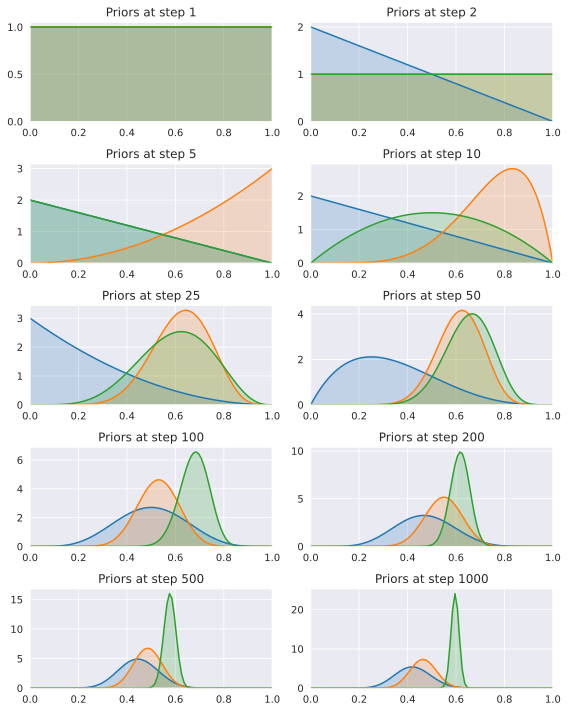

In [4]:
# Simulate multi-armed bandit process and update posteriors

# Setup plot
fig, axs = plt.subplots(5, 2, figsize=(8, 10))
axs = axs.flat

# The number of trials and wins will represent the prior for each
#  bandit with the help of the Beta distribution.
trials = [0, 0, 0]  # Number of times we tried each bandit
wins = [0, 0, 0]  # Number of wins for each bandit

n = 1000
# Run the trail for `n` steps
for step in range(1, n+1):
    # Define the prior based on current observations
    bandit_priors = [
        stats.beta(a=1+w, b=1+t-w) for t, w in zip(trials, wins)]
    # plot prior 
    if step in plots:
        plot(bandit_priors, step, next(axs))
    # Sample a probability theta for each bandit
    theta_samples = [
        d.rvs(1) for d in bandit_priors
    ]
    # choose a bandit
    chosen_bandit = np.argmax(theta_samples)
    # Pull the bandit
    x = pull(chosen_bandit)
    # Update trials and wins (defines the posterior)
    trials[chosen_bandit] += 1
    wins[chosen_bandit] += x

plt.tight_layout()
plt.show()

In [5]:
# Print final outcome and number of test needed per bandit
emperical_p_bandits = [(1+w) / (1+t) for t, w in zip(trials, wins)]
for i in range(nb_bandits):
    print((f'True prob={p_bandits[i]:.2f};  '
           f'Emperical prob={emperical_p_bandits[i]:.2f};  '
           f'Trials={trials[i]:d}'))
#

True prob=0.45;  Emperical prob=0.43;  Trials=43
True prob=0.55;  Emperical prob=0.47;  Trials=82
True prob=0.60;  Emperical prob=0.60;  Trials=875


Note above that the algorithm quickly converges to select the bandit with the highest probability of winning. After 1000 iterations it has chosen the winning bandit 10 times more often than one of the other bandits. 
See the further readings below if you want to know how to compute the probability that the winning bandit is better than the others [[2](#Further-readings)].

## Further readings

1. [Understanding the beta distribution (using baseball statistics)](http://varianceexplained.org/statistics/beta_distribution_and_baseball/) - David Robinson
2. [Formulas for Bayesian A/B Testing](http://www.evanmiller.org/bayesian-ab-testing.html) - Evan Miller

In [6]:
# Python package versions used
%load_ext watermark
%watermark --python
%watermark --iversions
#

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.23.0

numpy     : 1.20.2
matplotlib: 3.4.1
seaborn   : 0.11.1
scipy     : 1.6.3



###### Version history
* _2018-09-26_ : Published
* _2020-10-21_ : Updated packages and figures
* _2021-05-01_ : Updated packages, use watermark for versions.

This post at <a rel="canonical" href="https://peterroelants.github.io/posts/multi-armed-bandit-implementation/">peterroelants.github.io</a> is generated from an Python notebook file. [Link to the full IPython notebook file](https://github.com/peterroelants/peterroelants.github.io/blob/master/notebooks/misc/multi-armed-bandit-implementation.ipynb)